#Data preparation

##Import and verify

In [ ]:
import numpy as np

# Assuming dungeons_dataset.npy is located in the current working directory
dataset_file = 'dungeons_dataset.npy'

# Load the dataset
try:
    dungeons_data = np.load(dataset_file)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: Dataset file '{dataset_file}' not found.")
    # Handle the case where the file is not found
    dungeons_data = None

# Verify the dataset shape and contents
if dungeons_data is not None:
    # Check the shape of the dataset
    dataset_shape = dungeons_data.shape
    print(f"Dataset shape: {dataset_shape}")

    # Check if any record is missing (e.g., NaN values or empty entries)
    if not np.any(np.isnan(dungeons_data)) and not np.any(np.isinf(dungeons_data)):
        print("No missing records found.")
    else:
        print("There are missing records in the dataset.")
else:
    print("Dataset not loaded, cannot perform further verification.")


Dataset loaded successfully.
Dataset shape: (253, 8, 8)
No missing records found.


##Augment the data

In [ ]:
import numpy as np
from scipy.ndimage import rotate

# Assuming dungeons_dataset.npy is already loaded into dungeons_data
# dungeons_data.shape should be (253, 8, 8)

# Function to augment dataset
def augment_dataset(dataset):
    augmented_images = []

    for image in dataset:
        augmented_images.append(image)  # Original image

        # Rotate by 90 degrees
        rotated_90 = rotate(image, 90, reshape=False)
        augmented_images.append(rotated_90)

        # Rotate by 180 degrees
        rotated_180 = rotate(image, 180, reshape=False)
        augmented_images.append(rotated_180)

        # Rotate by 270 degrees
        rotated_270 = rotate(image, 270, reshape=False)
        augmented_images.append(rotated_270)

        # Flip horizontally
        flipped_horizontal = np.fliplr(image)
        augmented_images.append(flipped_horizontal)

        # Flip vertically
        flipped_vertical = np.flipud(image)
        augmented_images.append(flipped_vertical)

    return np.array(augmented_images)

# Augment the dataset
augmented_data = augment_dataset(dungeons_data)
print(f"Original dataset shape: {dungeons_data.shape}")
print(f"Augmented dataset shape: {augmented_data.shape}")



Original dataset shape: (253, 8, 8)
Augmented dataset shape: (1518, 8, 8)


##Visualise a subset

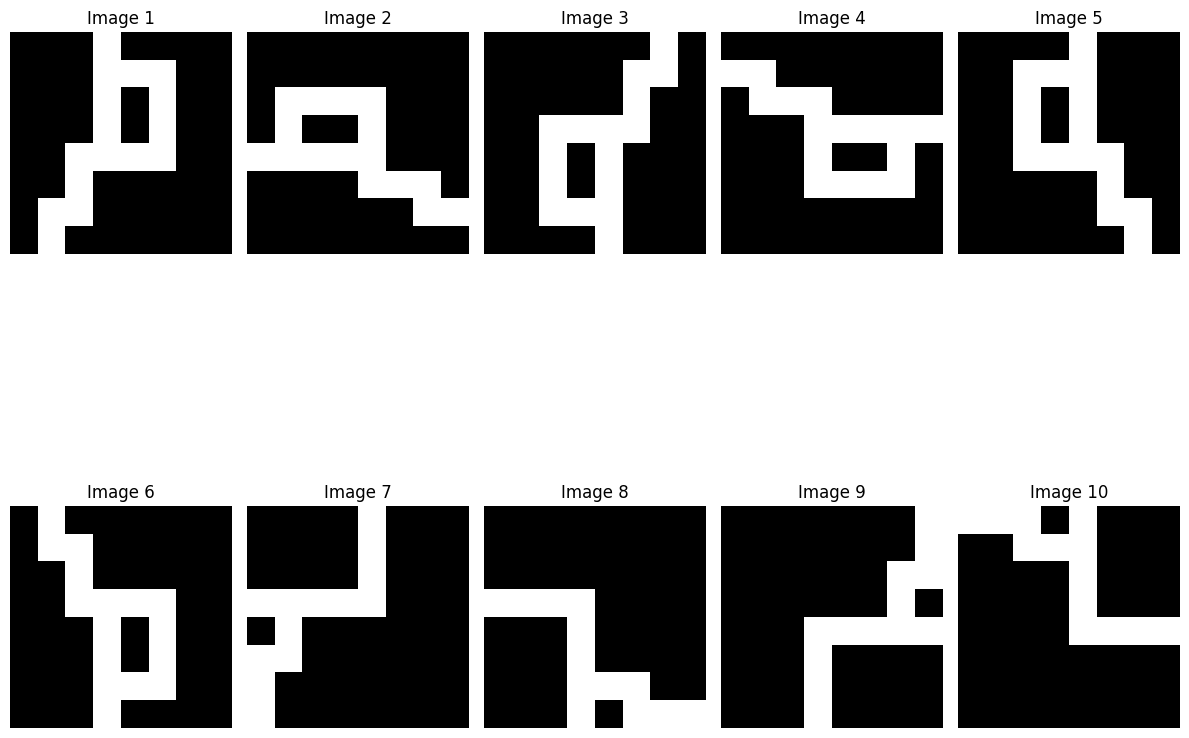

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming dungeons_dataset.npy is already loaded into dungeons_data
# dungeons_data.shape should be (253, 8, 8)

# Function to plot a subset of the dataset with correct colors
def plot_dataset_subset(dataset, num_images_to_plot=10):
    num_cols = 5  # Number of columns in the plot grid
    num_rows = (num_images_to_plot + num_cols - 1) // num_cols  # Calculate number of rows based on num_images_to_plot

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    for i in range(num_images_to_plot):
        ax = axes.flat[i]
        ax.imshow(dataset[i], cmap='gray', vmin=0, vmax=1)  # Use 'gray' colormap with vmin=0 and vmax=1
        ax.set_title(f"Image {i+1}")
        ax.axis('off')

    # Hide any unused subplot axes
    for j in range(num_images_to_plot, num_rows*num_cols):
        axes.flat[j].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize a subset of the dataset
num_images_to_plot = 10  # Adjust the number of images to plot
plot_dataset_subset(augmented_data, num_images_to_plot)


##Normalize & Formatting

In [ ]:
import numpy as np

# Assuming dungeons_dataset.npy is already loaded into dungeons_data
# dungeons_data.shape should be (253, 8, 8)

# Step 1: Normalize the dataset
normalized_data = augmented_data.astype(np.float32)  # Convert to float32 for compatibility
normalized_data /= 1.0  # Scale to range [0, 1]

# Step 2: Reshape the dataset
num_samples = augmented_data.shape[0]
flattened_size = np.prod(augmented_data.shape[1:])  # 8*8 = 64
reshaped_data = normalized_data.reshape(num_samples, flattened_size)

# Example: Print shapes before and after normalization and reshaping
print(f"Original dataset shape: {augmented_data.shape}")
print(f"Normalized dataset shape: {normalized_data.shape}")
print(f"Reshaped dataset shape: {reshaped_data.shape}")


Original dataset shape: (1518, 8, 8)
Normalized dataset shape: (1518, 8, 8)
Reshaped dataset shape: (1518, 64)


##Split the dataset

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming reshaped_data is already prepared from the previous steps
# reshaped_data.shape should be (253, 64)

# Splitting the dataset into train and test sets
train_data, test_data = train_test_split(reshaped_data, test_size=0.2, random_state=42)

# Example: Print shapes of train and test sets
print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")


Train dataset shape: (1214, 64)
Test dataset shape: (304, 64)


#VAE Model

##Build and train

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.15.0


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 dense_9 (Dense)             (None, 32)                   2080      ['input_7[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 8)                    264       ['dense_9[0][0]']             
                                                                                                  
 z_log_var (Dense)           (None, 8)                    264       ['dense_9[0][0]']             
                                                                                            

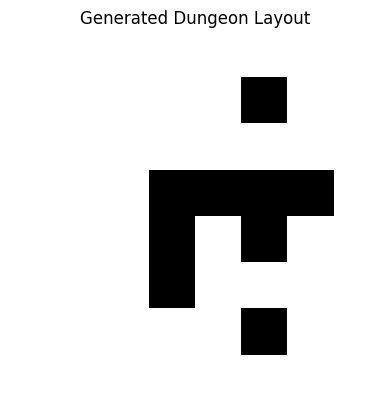

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define the VAE model
latent_dim = 8  # Dimensionality of the latent space

# Encoder network
encoder_inputs = tf.keras.Input(shape=(64,))
x = layers.Dense(32, activation='relu')(encoder_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])

encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder network
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation='relu')(latent_inputs)
outputs = layers.Dense(64, activation='sigmoid')(x)  # Sigmoid activation for binary outputs

decoder = models.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')

# Loss function
reconstruction_loss = tf.keras.losses.binary_crossentropy(encoder_inputs, outputs)
reconstruction_loss *= 64  # Since binary cross-entropy gives the mean over all dimensions

kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile the VAE model
vae.compile(optimizer='adam')

# Train the VAE model
history = vae.fit(train_data, epochs=1000, batch_size=32, validation_data=(test_data, None))

# Function to generate an image from random latent vector
def generate_image(decoder, latent_dim=8):
    # Sample a random point from the latent space
    latent_sample = np.random.normal(size=(1, latent_dim)).astype('float32')

    # Decode the latent vector to get the generated image
    generated_image = decoder.predict(latent_sample)

    return generated_image.reshape(8, 8)  # Reshape to original image dimensions

# Generate and visualize an image
generated_image = generate_image(decoder)

# Threshold to convert grayscale to binary
binary_image = (generated_image > 0.5).astype(int)

# Plot the generated binary image
plt.imshow(binary_image, cmap='binary')
plt.title('Generated Dungeon Layout')
plt.axis('off')
plt.show()


##Generate & Visualize

In [17]:
from google.colab import drive
drive.mount('/content/drive/')



Mounted at /content/drive/


In [ ]:
# Save the encoder and decoder
encoder.save('/mnt/drive/MyDrive/encoder.h5')
decoder.save('/mnt/drive/MyDrive/decoder.h5')

# Save the entire VAE model
vae.save('/mnt/drive/MyDrive/vae.h5')


1/1 [==============================] - 0s 61ms/step


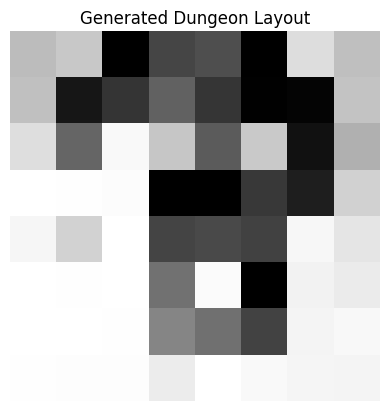

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved decoder model
decoder = load_model('/content/drive/MyDrive/decoder.h5')

# Function to generate an image from random latent vector
def generate_image(decoder, latent_dim=8):
    # Sample a random point from the latent space
    latent_sample = np.random.normal(size=(1, latent_dim)).astype('float32')

    # Decode the latent vector to get the generated image
    generated_image = decoder.predict(latent_sample)

    return generated_image.reshape(8, 8)  # Reshape to original image dimensions

# Generate an image
generated_image = generate_image(decoder)

# Plot the generated image
plt.imshow(generated_image, cmap='binary')
plt.title('Generated Dungeon Layout')
plt.axis('off')
plt.show()


#Correction Algorithm


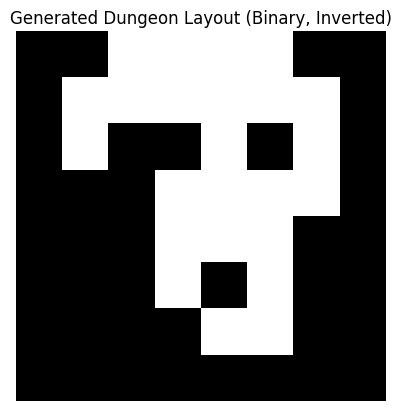

In [24]:
def convert_to_binary(image, threshold=0.5, invert=False):
    # Apply thresholding
    binary_image = np.where(image > threshold, 1.0, 0.0)

    # Invert colors if specified
    if invert:
        binary_image = 1.0 - binary_image

    return binary_image

# Convert grayscale image to binary and invert colors
binary_threshold = 0.5  # Adjust this threshold as needed
invert_colors = True  # Set to True to invert colors
binary_image = convert_to_binary(generated_image, threshold=binary_threshold, invert=invert_colors)

# Plot the generated binary image with inverted colors
plt.imshow(binary_image, cmap='binary')
plt.title('Generated Dungeon Layout (Binary, Inverted)')
plt.axis('off')
plt.show()

#Evaluation

In [28]:
def generate_samples(decoder, num_samples=304, latent_dim=8):
    latent_samples = np.random.normal(size=(num_samples, latent_dim)).astype('float32')
    generated_samples = decoder.predict(latent_samples)
    return generated_samples

num_samples = test_data.shape[0]  # Match the number of test samples
generated_samples = generate_samples(decoder, num_samples)


10/10 [==============================] - 0s 13ms/step


In [29]:
def convert_to_binary(images):
    return (images > 0.5).astype(int)

binary_generated_samples = convert_to_binary(generated_samples)
binary_test_data = convert_to_binary(test_data)



In [31]:
!pip install prdc

In [35]:
from prdc import compute_prdc

def compute_precision_recall(real_images, generated_images):
    real_images_flat = real_images.reshape((real_images.shape[0], -1))  # Flatten images
    generated_images_flat = generated_images.reshape((generated_images.shape[0], -1))  # Flatten images

    metrics = compute_prdc(real_features=real_images_flat, fake_features=generated_images_flat, nearest_k=5)
    return metrics

precision_recall_metrics = compute_precision_recall(binary_test_data, binary_generated_samples)
print(f"Precision: {precision_recall_metrics['precision']}")
print(f"Recall: {precision_recall_metrics['recall']}")

from scipy.spatial.distance import pdist

def measure_diversity(images):
    images_flat = images.reshape((images.shape[0], -1))  # Flatten images
    distances = pdist(images_flat, metric='euclidean')
    diversity = np.mean(distances)
    return diversity

diversity_score = measure_diversity(binary_generated_samples)
print(f"Diversity Score: {diversity_score}")

def measure_coverage(real_images, generated_images, threshold=0.5):
    real_images_flat = real_images.reshape((real_images.shape[0], -1))  # Flatten images
    generated_images_flat = generated_images.reshape((generated_images.shape[0], -1))  # Flatten images

    covered = 0
    for real_image in real_images_flat:
        distances = np.linalg.norm(generated_images_flat - real_image, axis=1)
        if np.any(distances < threshold):
            covered += 1

    coverage = covered / real_images_flat.shape[0]
    return coverage

coverage_score = measure_coverage(binary_test_data, binary_generated_samples)
print(f"Coverage Score: {coverage_score}")


Num real: 304 Num fake: 304
Precision: 0.9210526315789473
Recall: 0.003289473684210526
Diversity Score: 3.3410601822311667
Coverage Score: 0.0
